In [1]:
from datasets import load_dataset
import re
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from collections import Counter
import os


In [2]:
dataset = load_dataset("ai4bharat/IndicCorpV2", "indiccorp_v2", split="guj_Gujr", streaming=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

In [3]:
sentence_end = re.compile(r'([\.!?])\s+')
def tokenize_sentences(paragraph: str) -> list:
    # Normalize whitespace
    text = paragraph.strip().replace("\n", " ")

    # Split on '.', '!' or '?' plus following space
    parts = sentence_end.split(text)

    sentences = []
    for i in range(0, len(parts) - 1, 2):
        sent = parts[i] + parts[i+1]
        sentences.append(sent.strip())

    if len(parts) % 2 == 1 and parts[-1].strip():
        sentences.append(parts[-1].strip())

    return sentences


In [4]:
# Word tokenization
# Unicode-aware regex patterns
URL_PATTERN    = r'https?://[^\s]+\.\w{2,}'
EMAIL_PATTERN  = r'[\w\.-]+@[\w\.-]+\.\w+'
DATE_PATTERN   = r'\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b'
DECIMAL_PATTERN = r'\d+\.\d+'
NUMBER_PATTERN = r'\d+'
# Gujarati words range: \u0A80–\u0AFF;
GUJ_WORD       = r'[\u0A80-\u0AFF]+'
PUNCT_PATTERN  = r'[^\w\s\u0A80-\u0AFF]'  # punctuation not part of Gujarati

# Combine all token rules
token_re = re.compile(
    f"{URL_PATTERN}|{EMAIL_PATTERN}|{DATE_PATTERN}|{DECIMAL_PATTERN}|{NUMBER_PATTERN}|{GUJ_WORD}|{PUNCT_PATTERN}"
)

def tokenize_words(sentence):
    return token_re.findall(sentence)


In [5]:
max_sentences = 100000  # Increased for better corpus size
batch_size = 10000     # Process in batches for memory efficiency
output_dir = "tokenized_gujarati_corpus"
os.makedirs(output_dir, exist_ok=True)


In [6]:
def process_and_save_batch(sentences_batch, batch_num):
    """Process a batch of sentences and save to parquet"""
    tokenized_sentences = []

    for sent in sentences_batch:
        tokens = tokenize_words(sent)
        if tokens:  # Only include sentences with tokens
            # Join tokens with spaces to create tokenized sentence
            tokenized_sentence = ' '.join(tokens)
            tokenized_sentences.append({
                'original_sentence': sent,
                'tokenized_sentence': tokenized_sentence,
                'token_count': len(tokens)
            })

    if tokenized_sentences:
        # Create DataFrame
        df = pd.DataFrame(tokenized_sentences)

        # Save as parquet with compression
        output_file = os.path.join(output_dir, f"gujarati_tokenized_batch_{batch_num:04d}.parquet")
        df.to_parquet(
            output_file,
            compression='snappy',  # Fast compression with good ratio
            engine='pyarrow'
        )

        print(f"Saved batch {batch_num} with {len(tokenized_sentences)} sentences to {output_file}")
        return len(tokenized_sentences), df['tokenized_sentence'].tolist()

    return 0, []


In [7]:
# Process dataset in batches
sentence_count = 0
batch_num = 0
current_batch = []
all_tokens = []
batch_stats = []

print("Starting corpus processing...")


Starting corpus processing...


In [8]:
for data in dataset:
    if max_sentences is not None and sentence_count >= max_sentences:
        break

    text = data.get("text", "").strip()
    if not text:
        continue

    sentences = tokenize_sentences(text)
    for sent in sentences:
        if max_sentences is not None and sentence_count >= max_sentences:
            break

        current_batch.append(sent)
        sentence_count += 1

        # Process batch when it reaches batch_size
        if len(current_batch) >= batch_size:
            batch_sentences, batch_tokenized = process_and_save_batch(current_batch, batch_num)
            if batch_sentences > 0:
                # Collect tokens for overall statistics
                for tokenized_sent in batch_tokenized:
                    all_tokens.extend(tokenized_sent.split())

                batch_stats.append({
                    'batch_num': batch_num,
                    'sentences': batch_sentences
                })

            current_batch = []
            batch_num += 1


Saved batch 0 with 9999 sentences to tokenized_gujarati_corpus/gujarati_tokenized_batch_0000.parquet
Saved batch 1 with 9998 sentences to tokenized_gujarati_corpus/gujarati_tokenized_batch_0001.parquet
Saved batch 2 with 9998 sentences to tokenized_gujarati_corpus/gujarati_tokenized_batch_0002.parquet
Saved batch 3 with 9998 sentences to tokenized_gujarati_corpus/gujarati_tokenized_batch_0003.parquet
Saved batch 4 with 10000 sentences to tokenized_gujarati_corpus/gujarati_tokenized_batch_0004.parquet
Saved batch 5 with 9998 sentences to tokenized_gujarati_corpus/gujarati_tokenized_batch_0005.parquet
Saved batch 6 with 9998 sentences to tokenized_gujarati_corpus/gujarati_tokenized_batch_0006.parquet
Saved batch 7 with 9999 sentences to tokenized_gujarati_corpus/gujarati_tokenized_batch_0007.parquet
Saved batch 8 with 9999 sentences to tokenized_gujarati_corpus/gujarati_tokenized_batch_0008.parquet
Saved batch 9 with 9999 sentences to tokenized_gujarati_corpus/gujarati_tokenized_batch_00

In [9]:
# Process remaining sentences in the last batch
if current_batch:
    batch_sentences, batch_tokenized = process_and_save_batch(current_batch, batch_num)
    if batch_sentences > 0:
        for tokenized_sent in batch_tokenized:
            all_tokens.extend(tokenized_sent.split())

        batch_stats.append({
            'batch_num': batch_num,
            'sentences': batch_sentences
        })


In [10]:
total_sentences = sum(stat['sentences'] for stat in batch_stats)
total_words = len(all_tokens)
total_characters = sum(len(token) for token in all_tokens)
unique_tokens = set(all_tokens)


In [11]:
token_counts = Counter(all_tokens)
most_common = token_counts.most_common(100)


In [12]:
print("\n🔢 Top 100 Most Frequent Words:")
for i, (word, freq) in enumerate(most_common, 1):
    print(f"{i:>2}. {word:<15}  —  {freq:,} times")



🔢 Top 100 Most Frequent Words:
 1. .                —  96,827 times
 2. છે               —  63,146 times
 3. ,                —  46,822 times
 4. અને              —  28,565 times
 5. આ                —  18,318 times
 6. કે               —  16,257 times
 7. પણ               —  13,070 times
 8. માટે             —  12,940 times
 9. -                —  10,646 times
10. એક               —  9,998 times
11. કરી              —  9,814 times
12. પર               —  9,669 times
13. તે               —  8,503 times
14. જ                —  8,414 times
15. સાથે             —  8,322 times
16. હતી              —  8,270 times
17. તો               —  6,216 times
18. હતો              —  5,776 times
19. હતા              —  5,490 times
20. નથી              —  5,162 times
21. આવી              —  5,042 times
22. કરવામાં          —  4,987 times
23. જે               —  4,830 times
24. હતું             —  4,735 times
25. :                —  4,523 times
26. )                —  4,499 times
27. (                — 

# Task
Create a frequency distribution of the tokens in the dataset without using any predefined libraries. Identify stop words based on a frequency threshold and remove them from the tokenized dataset. Plot the frequency distribution of the top 100 most frequent words before removing stop words. Plot the frequency distribution of the top 100 most frequent words after removing stop words using three different frequency thresholds.

## Create frequency distribution

### Subtask:
Create a frequency distribution of the tokens in the dataset without using any predefined libraries.


**Reasoning**:
Initialize an empty dictionary and iterate through the `all_tokens` list to count the frequency of each token as instructed.



In [14]:
token_frequency = {}
for token in all_tokens:
    if token in token_frequency:
        token_frequency[token] += 1
    else:
        token_frequency[token] = 1

## Identify and remove stop words

### Subtask:
Identify stop words based on a frequency threshold and remove them from the tokenized dataset.


**Reasoning**:
Define frequency thresholds and iterate through them to identify and remove stop words from the tokenized sentences, saving the cleaned data for each threshold.



In [22]:
frequency_thresholds = [1000, 500, 200]
output_dir_cleaned = "cleaned_tokenized_gujarati_corpus"
os.makedirs(output_dir_cleaned, exist_ok=True)

# Reload tokenized sentences from parquet files for processing
# This assumes the parquet files saved in the previous steps are available
tokenized_sentences_list = []
for batch_num in range(batch_num + 1): # batch_num was incremented after the last batch
    input_file = os.path.join(output_dir, f"gujarati_tokenized_batch_{batch_num:04d}.parquet")
    if os.path.exists(input_file):
        df_batch = pd.read_parquet(input_file)
        tokenized_sentences_list.extend(df_batch['tokenized_sentence'].tolist())
    else:
        print(f"Warning: Batch file not found: {input_file}")


for threshold in frequency_thresholds:
    print(f"\nProcessing with frequency threshold: {threshold}")
    # Create a set of stop words based on the current threshold
    stop_words = {word for word, freq in token_frequency.items() if freq > threshold}

    cleaned_sentences_list = []
    for tokenized_sentence in tokenized_sentences_list:
        # Split the tokenized sentence string into individual tokens
        tokens = tokenized_sentence.split()
        # Filter out stop words
        cleaned_tokens = [token for token in tokens if token not in stop_words]
        # Join the remaining tokens back into a string
        cleaned_sentence = ' '.join(cleaned_tokens)
        cleaned_sentences_list.append(cleaned_sentence)

    # Save the cleaned data for the current threshold
    cleaned_df = pd.DataFrame({'cleaned_tokenized_sentence': cleaned_sentences_list})
    output_file_cleaned = os.path.join(output_dir_cleaned, f"gujarati_cleaned_threshold_{threshold}.parquet")
    cleaned_df.to_parquet(
        output_file_cleaned,
        compression='snappy',
        engine='pyarrow'
    )
    print(f"Saved cleaned data for threshold {threshold} to {output_file_cleaned}")



Processing with frequency threshold: 1000
Saved cleaned data for threshold 1000 to cleaned_tokenized_gujarati_corpus/gujarati_cleaned_threshold_1000.parquet

Processing with frequency threshold: 500
Saved cleaned data for threshold 500 to cleaned_tokenized_gujarati_corpus/gujarati_cleaned_threshold_500.parquet

Processing with frequency threshold: 200
Saved cleaned data for threshold 200 to cleaned_tokenized_gujarati_corpus/gujarati_cleaned_threshold_200.parquet


## Plot frequency distribution before stop words removal

### Subtask:
Plot the frequency distribution of the top 100 most frequent words before removing stop words.


**Reasoning**:
Import necessary libraries for plotting and data manipulation.



In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm

**Reasoning**:
Sort the token frequencies, extract the top 100, create a DataFrame, and plot the frequency distribution.



/tmp/ipython-input-482478392.py:41: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Gujarati UI.
  plt.tight_layout()
/tmp/ipython-input-482478392.py:41: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Gujarati UI.
  plt.tight_layout()


Using font: Noto Sans Gujarati UI


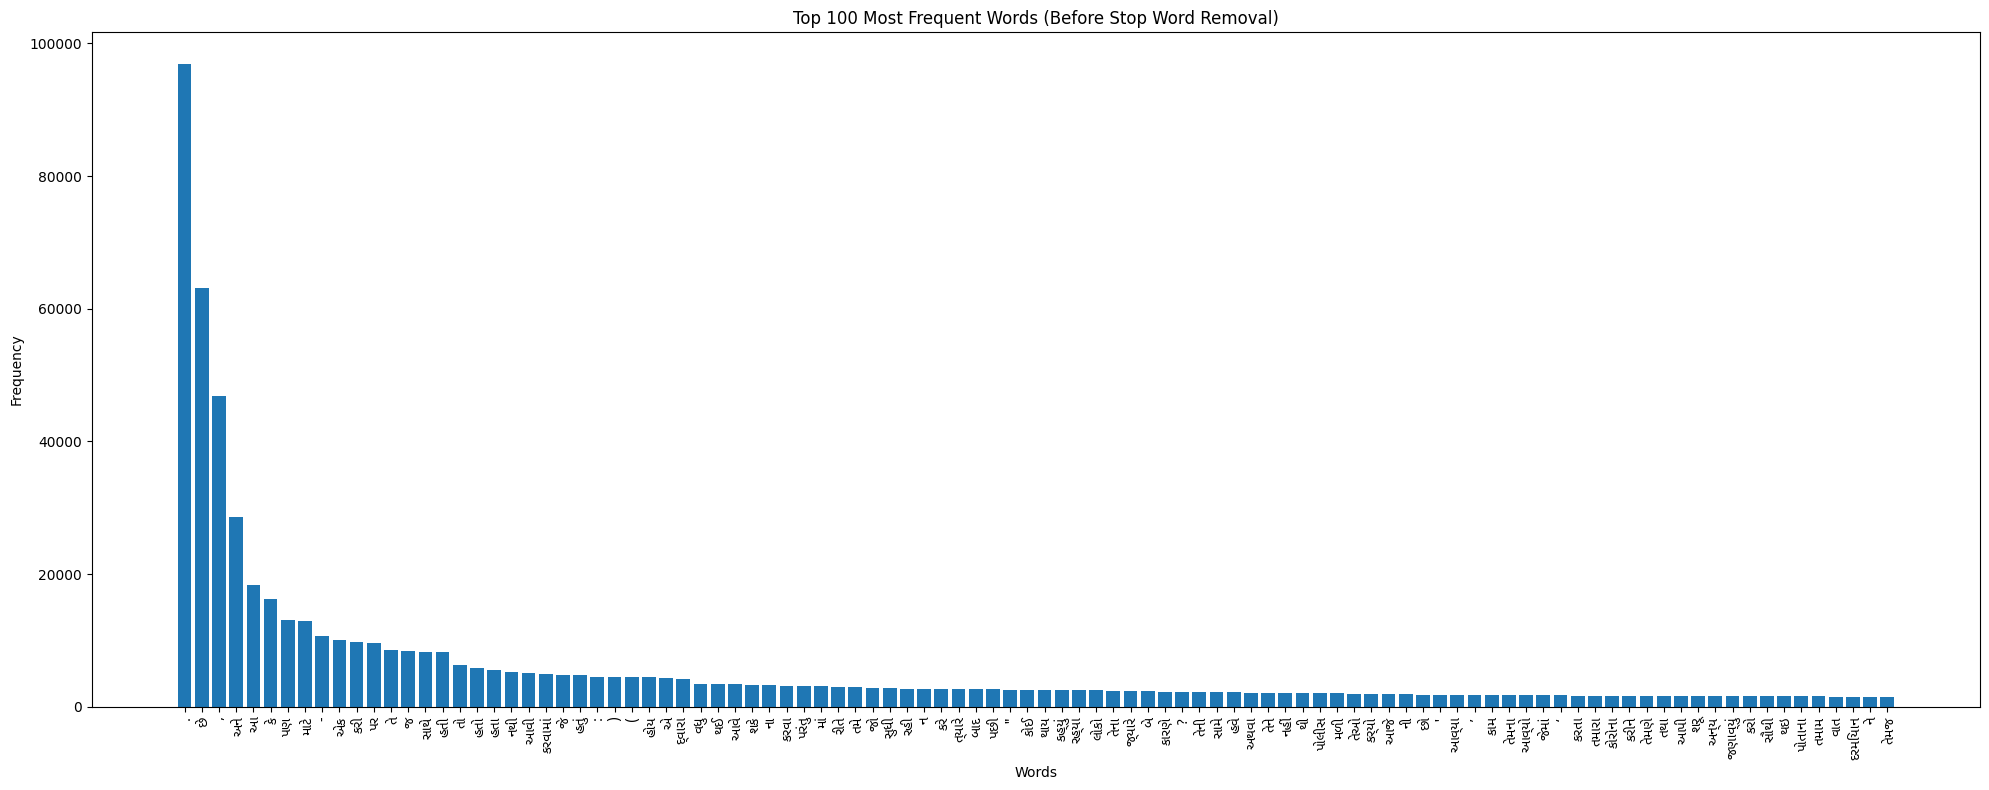

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm

# Find the path to Noto Sans Gujarati font
font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/'])
gujarati_font_path = None
for font_file in font_files:
    if 'NotoSansGujarati' in font_file and 'Regular' in font_file:
        gujarati_font_path = font_file
        break

if gujarati_font_path:
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [fm.FontProperties(fname=gujarati_font_path).get_name()]
    print(f"Using font: {plt.rcParams['font.sans-serif'][0]}")
else:
    print("NotoSansGujarati-Regular.ttf not found. Please ensure a Gujarati font is available.")

# You may also need to set the figure.autolayout to True to prevent labels overlapping
plt.rcParams['figure.autolayout'] = True


# Sort token_frequency by frequency in descending order
sorted_token_frequency = sorted(token_frequency.items(), key=lambda item: item[1], reverse=True)

# Extract the top 100 words and their frequencies
words = [item[0] for item in sorted_token_frequency[:100]]
frequencies = [item[1] for item in sorted_token_frequency[:100]]

# Create a pandas DataFrame
df_top100_before = pd.DataFrame({'Word': words, 'Frequency': frequencies})

# Create a bar plot
plt.figure(figsize=(20, 8))
plt.bar(df_top100_before['Word'], df_top100_before['Frequency'])
plt.title("Top 100 Most Frequent Words (Before Stop Word Removal)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=90, fontproperties=fm.FontProperties(fname=gujarati_font_path)) # Explicitly set font
plt.tight_layout()
plt.show()

## Plot frequency distribution after stop words removal

### Subtask:
Plot the frequency distribution of the top 100 most frequent words after removing stop words using three different frequency thresholds.


**Reasoning**:
Iterate through the frequency thresholds, load the cleaned data, calculate token frequencies, extract the top 100 words, and plot their frequency distribution for each threshold.



Using font: Noto Sans Gujarati UI

Plotting frequency distribution for threshold: 1000


/tmp/ipython-input-1237455956.py:67: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Gujarati UI.
  plt.tight_layout()
/tmp/ipython-input-1237455956.py:67: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Gujarati UI.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Gujarati UI.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Gujarati UI.
  fig.canvas.print_figure(bytes_io, **kw)


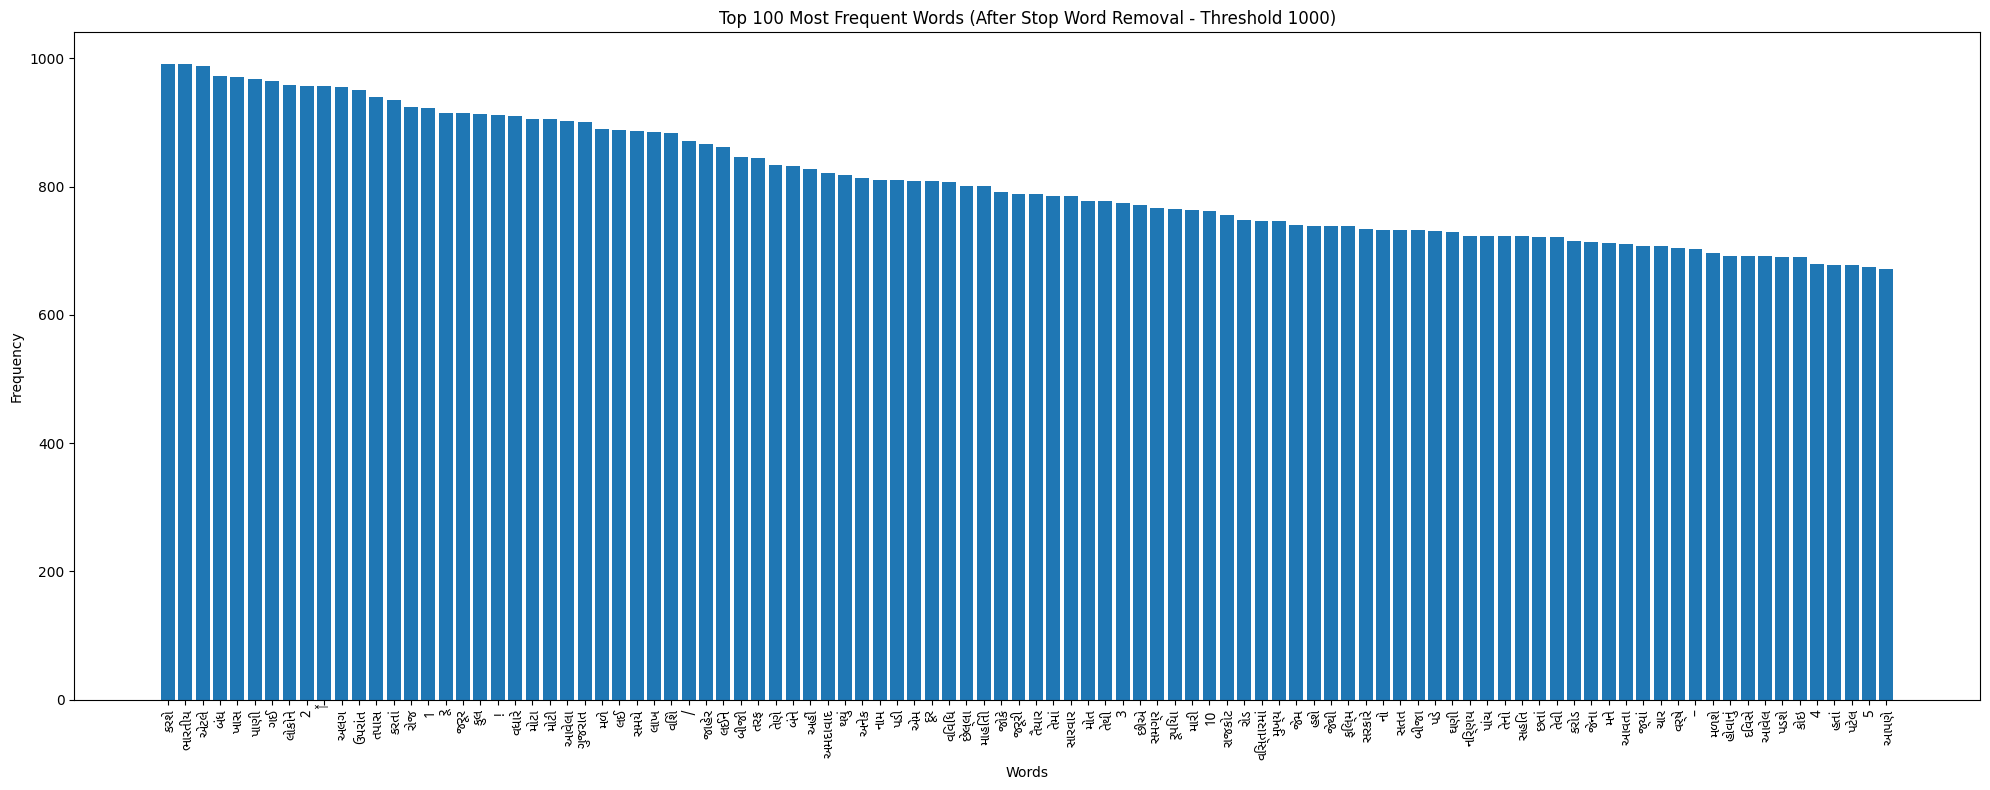


Plotting frequency distribution for threshold: 500


/tmp/ipython-input-1237455956.py:67: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Gujarati UI.
  plt.tight_layout()
/tmp/ipython-input-1237455956.py:67: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Gujarati UI.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Gujarati UI.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Gujarati UI.
  fig.canvas.print_figure(bytes_io, **kw)


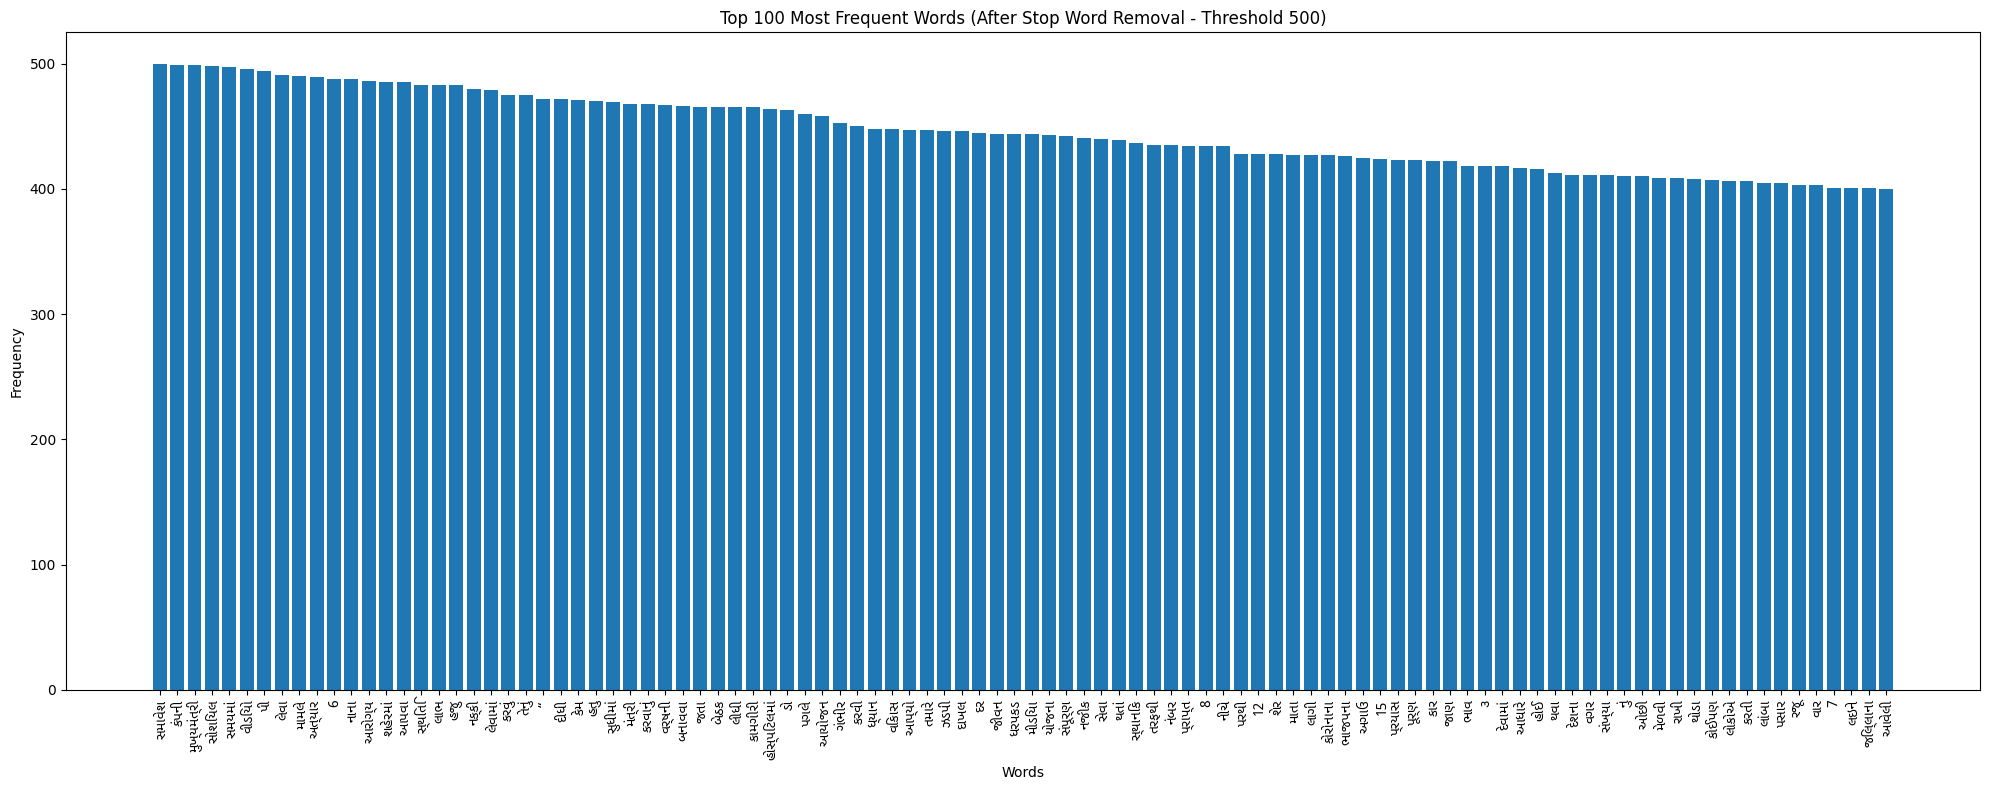


Plotting frequency distribution for threshold: 200


/tmp/ipython-input-1237455956.py:67: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Gujarati UI.
  plt.tight_layout()
/tmp/ipython-input-1237455956.py:67: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Gujarati UI.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Gujarati UI.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Gujarati UI.
  fig.canvas.print_figure(bytes_io, **kw)


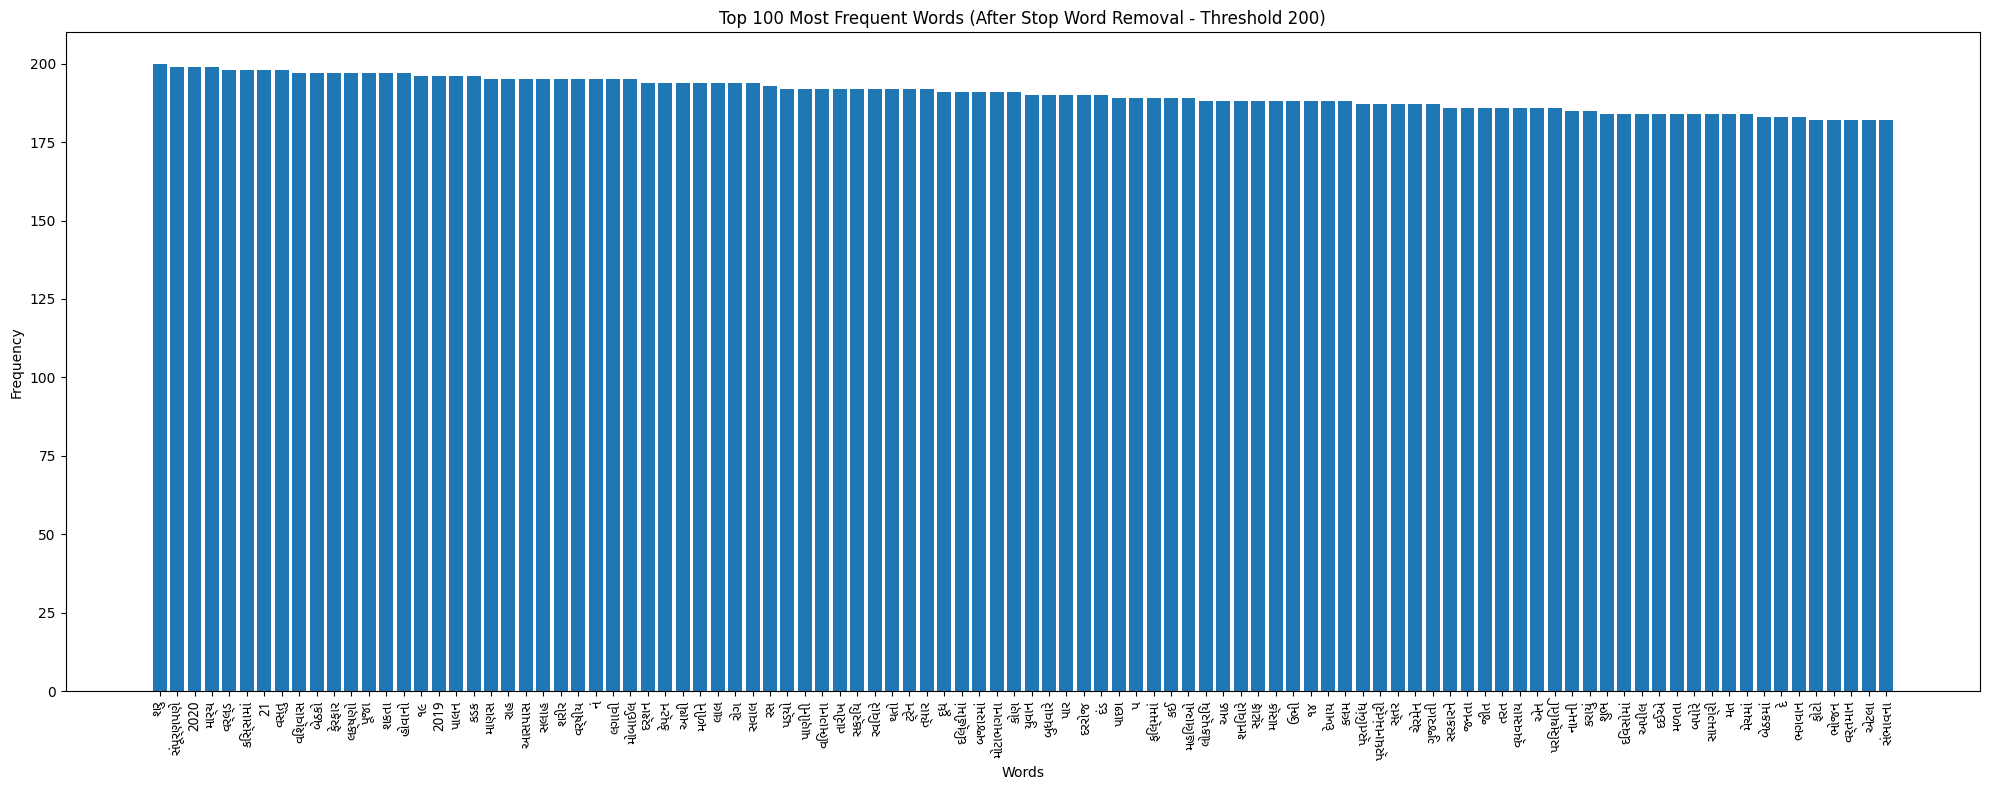

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm

# Find the path to Noto Sans Gujarati font
font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/'])
gujarati_font_path = None
for font_file in font_files:
    if 'NotoSansGujarati' in font_file and 'Regular' in font_file:
        gujarati_font_path = font_file
        break

if gujarati_font_path:
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [fm.FontProperties(fname=gujarati_font_path).get_name()]
    print(f"Using font: {plt.rcParams['font.sans-serif'][0]}")
else:
    print("NotoSansGujarati-Regular.ttf not found. Please ensure a Gujarati font is available.")

# You may also need to set the figure.autolayout to True to prevent labels overlapping
plt.rcParams['figure.autolayout'] = True


frequency_thresholds = [1000, 500, 200]
output_dir_cleaned = "cleaned_tokenized_gujarati_corpus"

for threshold in frequency_thresholds:
    print(f"\nPlotting frequency distribution for threshold: {threshold}")

    # Load the cleaned tokenized data for the current threshold
    input_file_cleaned = os.path.join(output_dir_cleaned, f"gujarati_cleaned_threshold_{threshold}.parquet")
    if not os.path.exists(input_file_cleaned):
        print(f"Error: Cleaned data file not found: {input_file_cleaned}")
        continue

    cleaned_df = pd.read_parquet(input_file_cleaned)

    # Calculate token frequencies for the cleaned data
    cleaned_token_frequency = {}
    for sentence in cleaned_df['cleaned_tokenized_sentence']:
        # Ensure sentence is a string and not None
        if isinstance(sentence, str):
            tokens = sentence.split()
            for token in tokens:
                if token in cleaned_token_frequency:
                    cleaned_token_frequency[token] += 1
                else:
                    cleaned_token_frequency[token] = 1

    # Sort token_frequency by frequency in descending order
    sorted_cleaned_token_frequency = sorted(cleaned_token_frequency.items(), key=lambda item: item[1], reverse=True)

    # Extract the top 100 words and their frequencies
    cleaned_words = [item[0] for item in sorted_cleaned_token_frequency[:100]]
    cleaned_frequencies = [item[1] for item in sorted_cleaned_token_frequency[:100]]

    # Create a pandas DataFrame
    df_top100_after = pd.DataFrame({'Word': cleaned_words, 'Frequency': cleaned_frequencies})

    # Create a bar plot
    plt.figure(figsize=(20, 8))
    plt.bar(df_top100_after['Word'], df_top100_after['Frequency'])
    plt.title(f"Top 100 Most Frequent Words (After Stop Word Removal - Threshold {threshold})")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90, fontproperties=fm.FontProperties(fname=gujarati_font_path)) # Explicitly set font
    plt.tight_layout()
    plt.show()

## Summary:

### Data Analysis Key Findings

*   Before removing stop words, the frequency distribution of the top 100 words was calculated and plotted, revealing the most common tokens in the dataset.
*   Stop words were identified based on token frequency thresholds of 1000, 500, and 200.
*   The tokenized dataset was cleaned by removing the identified stop words for each frequency threshold, and the cleaned data was saved.
*   After removing stop words using each of the three thresholds, the frequency distribution of the top 100 words was recalculated and plotted. These plots show the distribution of the most frequent words remaining after filtering based on different frequency criteria.

### Insights or Next Steps

*   Comparing the plots before and after stop word removal with different thresholds provides insight into which words are most affected by high frequency and how varying the threshold impacts the resulting top words.
*   The cleaned datasets generated with different stop word thresholds can be used for downstream natural language processing tasks such as topic modeling or text classification, allowing for experimentation with the impact of stop word removal on model performance.


In [33]:
!sudo apt-get update
!sudo apt-get install -y fonts-noto-cjk
!sudo apt-get install -y fonts-noto-unhinted
!sudo apt-get install -y fonts-noto-hinted

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,189 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,271 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,546 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:14 h